In [58]:
import json
import math
import os
from datetime import date

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import requests
from IPython.display import Image
from dotenv import load_dotenv
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

In [59]:
load_dotenv()
CLIENT_ID = os.environ.get('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')
GOOGLE_GEO_API_KEY = os.environ.get('GOOGLE_GEO_API_KEY')

# Draw Minsk post offices an the map

In [60]:
df_minsk = pd.read_csv('zip_codes_minsk_list.csv')
df_minsk.drop(columns=['Unnamed: 0'], inplace=True)
df_minsk.head()

,address,zip-code,lat,lng
0,"ул. Московская,16",220001,53.887919,27.538119
1,"ул. Сторожевская, 8",220002,53.912949,27.555453
2,"ул. Одинцова, 113",220003,53.900651,27.427532
3,"ул. М.Танка,36, к.2,",220004,53.908628,27.529463
4,"пр. Независимости, 46",220005,53.912815,27.580710


In [61]:
address = 'Minsk, BY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Minsk are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Minsk are 53.902334, 27.5618791.


In [76]:
map_minsk = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_minsk['lat'], df_minsk['lng'], df_minsk['zip-code'], df_minsk['address']):
    label = '{}; {}'.format(neighborhood, borough)
    label_f = folium.Popup(label, parse_html=True)
    tooltip = folium.Tooltip(label)
    folium.CircleMarker(
        (lat, lng),
        radius=5,
        popup=label_f,
        tooltip=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_minsk)  
    
map_minsk

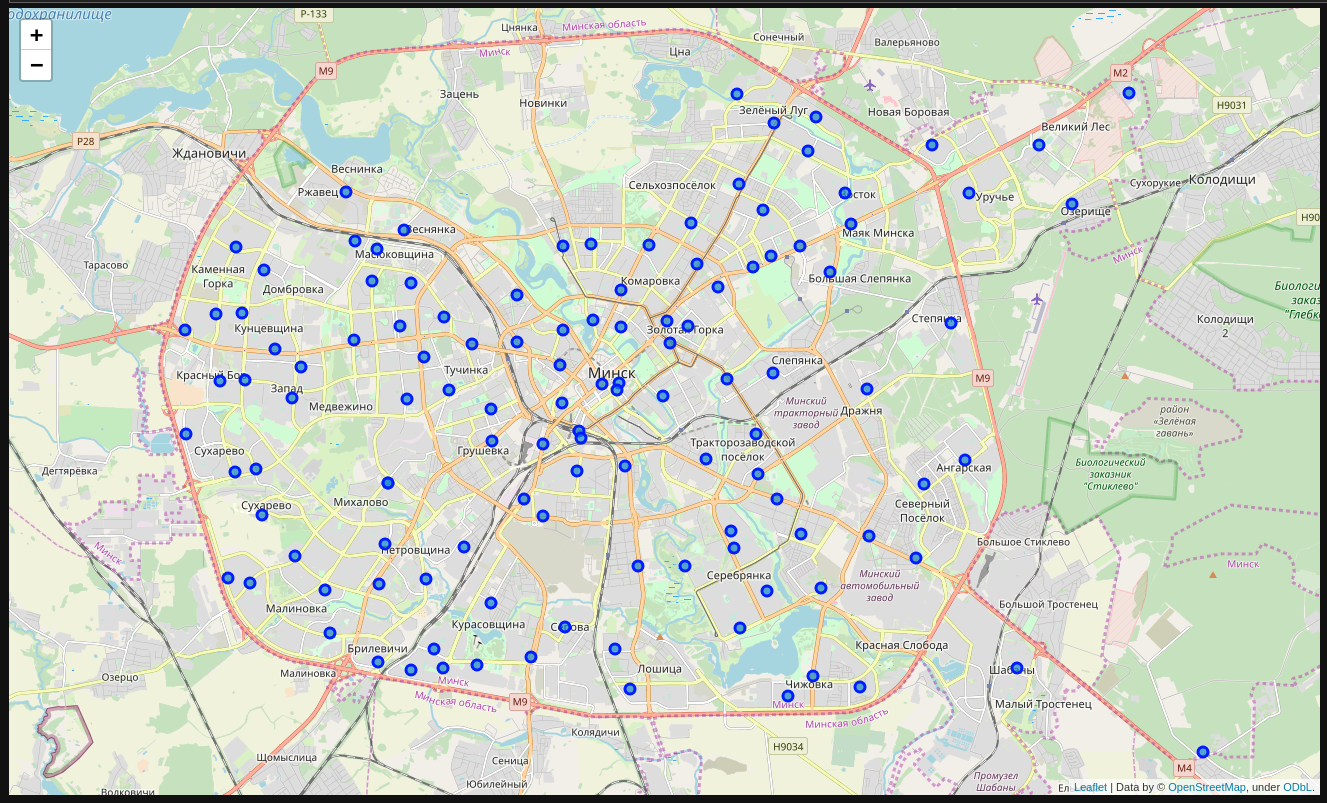

In [123]:
Image('zip code map minsk.png')

# Find Average distance between data points

In [63]:
def distance(_co: list) -> float:
        """
        wiki - https://...
        r = 6363.513 = for BLR, Minsk; evr. R on Earth = 6378.137 km
        :param _co: [lat A, lng A, lat B, lng B]
        """
        rad_lat_a = math.radians(_co[0])
        rad_lat_b = math.radians(_co[2])
        rad_lng_a = math.radians(_co[1])
        rad_lng_b = math.radians(_co[3])
        central_angle = math.acos(math.sin(rad_lat_a) * math.sin(rad_lat_b) +
                                  math.cos(rad_lat_a) * math.cos(rad_lat_b) * math.cos(rad_lng_a - rad_lng_b))
        r = 6378.137
        dist = r * central_angle  # km
        return dist

In [64]:
all_distances = []
for i in range(df_minsk.shape[0]):
    current_lat = df_minsk.iloc[i, 2]
    current_lng = df_minsk.iloc[i, 3]
    
    for y_lat, y_lng in zip(df_minsk['lat'], df_minsk['lng']):
        min_distance = None
        
        if current_lat != y_lat and current_lng != y_lng:
            current_distance = distance([current_lat, current_lat, y_lat, y_lng])
            
            if min_distance and current_distance < min_distance :
                min_distance = current_distance
            else:
                min_distance = current_distance
        else:
            continue
        
        all_distances.append(min_distance)

l = len(all_distances)
s = sum(all_distances)
avg_distance = s/l
print('list len:', l, ', avg.distance:', avg_distance)

list len: 14760 , avg.distance: 1717.4635539786188


In [65]:
print(None in all_distances, 0.0 in all_distances)
print(min(all_distances), max(all_distances))

False False
1683.9968762290766 1729.7109234822397


# Load data from Foursquare

In [175]:
LIMIT = 100
RADIUS = int(avg_distance / 2)   # meters
VERSION = date.today().strftime("%Y%m%d")
print('RADIUS:', RADIUS, 'm, VERSION:', VERSION)

RADIUS: 858 m, VERSION: 20200128


In [79]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, c_lat, c_lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            c_lat, 
            c_lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        with open('foursquare_data_json/data_%s.json' % name, 'w') as outfile:
                json.dump(results, outfile)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            c_lat, 
            c_lng,
            v['venue']['id'],
            v['venue']['name'],
            # v['venue']['location']['address'],
            round(float(v['venue']['location']['lat']), 7), 
            round(float(v['venue']['location']['lng']), 7), 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zip-code',
                             'neighborhood-latitude',
                             'neighborhood-longitude',
                             'venue-id',
                             'venue-name', 
                            # 'venue-address', 
                             'venue-latitude', 
                             'venue-longitude', 
                             'venue-category']
    
    return nearby_venues

In [80]:
# minsk_venues = getNearbyVenues(
#     names=df_minsk['zip-code'],
#     latitudes=df_minsk['lat'],
#     longitudes=df_minsk['lng'],
#     radius=RADIUS
# )

# print('minsk_venues - done!')

minsk_venues - done!


In [81]:
# minsk_venues.to_csv('minsk_venues.csv')

In [154]:
minsk_venues = pd.read_csv('minsk_venues.csv')
minsk_venues.drop(columns=['Unnamed: 0'], inplace=True)
minsk_venues.head()

,zip-code,neighborhood-latitude,neighborhood-longitude,venue-id,venue-name,venue-latitude,venue-longitude,venue-category
0,220001,53.887919,27.538119,4c8cf10555fba093fdb663ab,Баня № 7,53.889164,27.540151,Bath House
1,220001,53.887919,27.538119,55b29ffa498e519a9a539ac1,Hampton by Hilton Minsk City Centre,53.888951,27.544090,Hotel
2,220001,53.887919,27.538119,5b7d910167e5f2002cbaa676,Love Is Muffin,53.887879,27.538036,Café
3,220001,53.887919,27.538119,5756af9c498e47bf24348c6f,ціКава,53.888720,27.543410,Coffee Shop
4,220001,53.887919,27.538119,53653dee498ec5bdccef681a,Renaissance Minsk Hotel,53.892496,27.528823,Hotel


In [155]:
minsk_venues.shape

(4057, 8)

# Clean data, delete duplicated

In [156]:
venues_id = minsk_venues['venue-id']
duplicated = minsk_venues[venues_id.isin(venues_id[venues_id.duplicated()])]
duplicated

,zip-code,neighborhood-latitude,neighborhood-longitude,venue-id,venue-name,venue-latitude,venue-longitude,venue-category
0,220001,53.887919,27.538119,4c8cf10555fba093fdb663ab,Баня № 7,53.889164,27.540151,Bath House
1,220001,53.887919,27.538119,55b29ffa498e519a9a539ac1,Hampton by Hilton Minsk City Centre,53.888951,27.544090,Hotel
3,220001,53.887919,27.538119,5756af9c498e47bf24348c6f,ціКава,53.888720,27.543410,Coffee Shop
4,220001,53.887919,27.538119,53653dee498ec5bdccef681a,Renaissance Minsk Hotel,53.892496,27.528823,Hotel
5,220001,53.887919,27.538119,4f622d94e4b0ee949a050770,Wellness Club «Экомедсервис»,53.890081,27.542873,Gym / Fitness Center
...,...,...,...,...,...,...,...,...
4025,220140,53.907095,27.446173,4f7abb0be4b0ddbcd476725a,5 элемент,53.900413,27.446825,Electronics Store
4029,220140,53.907095,27.446173,4e5bcbba45dd705592b51b2b,"""Будьте Здоровы!"" салон-магазин массажного обо...",53.907484,27.458570,Spa
4033,220141,53.938677,27.684619,4e31aba5e4cde9495fd4bf02,"Парк ""Уручье"" (Парк ва Уруччы)",53.944217,27.677726,Park
4034,220141,53.938677,27.684619,528b17a3498ed0b9b9be0b71,CoolCoffee,53.945419,27.683210,Coffee Shop


In [157]:
minsk_venues.index[minsk_venues['venue-id'] == '4c8cf10555fba093fdb663ab'].tolist()

[0, 547, 615, 2237]

In [158]:
minsk_venues.sort_values('zip-code', inplace=True)
minsk_venues.drop_duplicates(subset='venue-id', keep='first', inplace=True)
minsk_venues.reset_index(inplace=True)
minsk_venues

,index,zip-code,neighborhood-latitude,neighborhood-longitude,venue-id,venue-name,venue-latitude,venue-longitude,venue-category
0,0,220001,53.887919,27.538119,4c8cf10555fba093fdb663ab,Баня № 7,53.889164,27.540151,Bath House
1,25,220001,53.887919,27.538119,55324a0e498ed648ac27b168,Пряности и Сладости,53.889623,27.539458,Coffee Shop
2,26,220001,53.887919,27.538119,5808efce38fad613f494ed5a,Корона,53.882019,27.537994,Supermarket
3,27,220001,53.887919,27.538119,547eb9bc498e4a242648aa28,lobby bar,53.892482,27.528910,Bar
4,28,220001,53.887919,27.538119,5a97ec7b356b4925230a62e9,Doner King,53.885046,27.540526,Doner Restaurant
...,...,...,...,...,...,...,...,...,...
2407,4035,220141,53.938677,27.684619,4ee86f5b991154b31c163fc8,Лес в Уручье,53.935551,27.694087,Park
2408,4031,220141,53.938677,27.684619,520f2aa911d2b02853cafeed,OZ.by,53.943442,27.685734,Bookstore
2409,4055,220141,53.938677,27.684619,50581143e4b0ccc7ceed544a,Остановка «Станция метро “Уручье”»,53.945476,27.688469,Bus Stop
2410,4042,220141,53.938677,27.684619,5606536f498ec78f87e1daca,Вкус Востока,53.944706,27.686903,Falafel Restaurant


In [159]:
print('There are {} uniques categories.'.format(len(minsk_venues['venue-category'].unique())))

There are 317 uniques categories.


# Analyze Each Neighborhood

In [160]:
# one hot encoding
minsk_onehot = pd.get_dummies(minsk_venues[['venue-category']], prefix="", prefix_sep="")

# add neighborhood column back to data-frame
minsk_onehot['zip-code'] = minsk_venues['zip-code'] 

# move neighborhood column to the first column
fixed_columns = [minsk_onehot.columns[-1]] + list(minsk_onehot.columns[:-1])
minsk_onehot = minsk_onehot[fixed_columns]

minsk_onehot.head()

,zip-code,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,220001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,220001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,220001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,220001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,220001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [161]:
minsk_grouped = minsk_onehot.groupby('zip-code').mean().reset_index()
print(minsk_grouped.shape)
minsk_grouped.head()

(121, 318)


,zip-code,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,220001,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0
1,220002,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.021978,0.0,0.00,0.000000,0.0,0.0,0.010989,0.0,0.0
2,220003,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.000000,0.0,0.00,0.045455,0.0,0.0,0.000000,0.0,0.0
3,220004,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.000000,0.0,0.00,0.038462,0.0,0.0,0.019231,0.0,0.0
4,220005,0.0,0.0,0.0,0.0,0.01,0.0,0.04,0.0,0.0,...,0.0,0.000000,0.0,0.03,0.000000,0.0,0.0,0.000000,0.0,0.0


### sort the venues in descending order

In [162]:
def return_most_common_venues(row, _num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:_num_top_venues]

### create the new data-frame and display the top 10 venues for each neighborhood

In [163]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['zip-code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new data-frame
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['zip-code'] = minsk_grouped['zip-code']

for ind in np.arange(minsk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(minsk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,220001,Coffee Shop,Gym / Fitness Center,Hotel,Dance Studio,Doner Restaurant,Bakery,Metro Station,Theater,Spa,Souvenir Shop
1,220002,Hotel,Café,Coffee Shop,Cocktail Bar,Fountain,Bar,Park,Gym,Spa,Gym / Fitness Center
2,220003,Bus Stop,Department Store,Boutique,Pharmacy,Beer Store,Gourmet Shop,Park,Café,Hardware Store,Furniture / Home Store
3,220004,Gym,Clothing Store,Concert Hall,Coffee Shop,Café,Wine Shop,Big Box Store,Bike Rental / Bike Share,Go Kart Track,Gift Shop
4,220005,Coffee Shop,Cosmetics Shop,Arcade,Dance Studio,Pharmacy,Wine Bar,Café,Sporting Goods Shop,Beer Bar,Tea Room


# Cluster Neighborhoods

### Run k-means to cluster the neighborhood into 5 clusters

In [164]:
# set number of clusters
kclusters = 5

minsk_grouped_clustering = minsk_grouped.drop('zip-code', 1)

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, random_state=0, n_init=12).fit(minsk_grouped_clustering)

# check cluster labels generated for each row in the data-frame
kmeans.labels_[:10]

array([2, 2, 4, 2, 2, 2, 4, 2, 2, 2], dtype=int32)

### new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [165]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster-label', kmeans.labels_)

minsk_merged = df_minsk

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
minsk_merged = minsk_merged.join(neighborhoods_venues_sorted.set_index('zip-code'), on='zip-code')

In [166]:
minsk_merged.head()

,address,zip-code,lat,lng,cluster-label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"ул. Московская,16",220001,53.887919,27.538119,2.0,Coffee Shop,Gym / Fitness Center,Hotel,Dance Studio,Doner Restaurant,Bakery,Metro Station,Theater,Spa,Souvenir Shop
1,"ул. Сторожевская, 8",220002,53.912949,27.555453,2.0,Hotel,Café,Coffee Shop,Cocktail Bar,Fountain,Bar,Park,Gym,Spa,Gym / Fitness Center
2,"ул. Одинцова, 113",220003,53.900651,27.427532,4.0,Bus Stop,Department Store,Boutique,Pharmacy,Beer Store,Gourmet Shop,Park,Café,Hardware Store,Furniture / Home Store
3,"ул. М.Танка,36, к.2,",220004,53.908628,27.529463,2.0,Gym,Clothing Store,Concert Hall,Coffee Shop,Café,Wine Shop,Big Box Store,Bike Rental / Bike Share,Go Kart Track,Gift Shop
4,"пр. Независимости, 46",220005,53.912815,27.580710,2.0,Coffee Shop,Cosmetics Shop,Arcade,Dance Studio,Pharmacy,Wine Bar,Café,Sporting Goods Shop,Beer Bar,Tea Room


### delete rows with 'nan' values, and transform 'Cluster Labels' to int type

In [167]:
minsk_merged.isnull().sum()

address                   0
zip-code                  0
lat                       0
lng                       0
cluster-label             1
1st Most Common Venue     1
2nd Most Common Venue     1
3rd Most Common Venue     1
4th Most Common Venue     1
5th Most Common Venue     1
6th Most Common Venue     1
7th Most Common Venue     1
8th Most Common Venue     1
9th Most Common Venue     1
10th Most Common Venue    1
dtype: int64

In [168]:
minsk_merged.dropna(inplace=True)
# toronto_merged['Cluster Labels'].replace(np.nan, -1, inplace=True)
minsk_merged['cluster-label'] = minsk_merged['cluster-label'].astype(int)
minsk_merged['cluster-label'].value_counts()

2    62
4    46
0    10
1     2
3     1
Name: cluster-label, dtype: int64

In [187]:
print(minsk_merged.shape)
minsk_merged.head()

(121, 15)


,address,zip-code,lat,lng,cluster-label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"ул. Московская,16",220001,53.887919,27.538119,2,Coffee Shop,Gym / Fitness Center,Hotel,Dance Studio,Doner Restaurant,Bakery,Metro Station,Theater,Spa,Souvenir Shop
1,"ул. Сторожевская, 8",220002,53.912949,27.555453,2,Hotel,Café,Coffee Shop,Cocktail Bar,Fountain,Bar,Park,Gym,Spa,Gym / Fitness Center
2,"ул. Одинцова, 113",220003,53.900651,27.427532,4,Bus Stop,Department Store,Boutique,Pharmacy,Beer Store,Gourmet Shop,Park,Café,Hardware Store,Furniture / Home Store
3,"ул. М.Танка,36, к.2,",220004,53.908628,27.529463,2,Gym,Clothing Store,Concert Hall,Coffee Shop,Café,Wine Shop,Big Box Store,Bike Rental / Bike Share,Go Kart Track,Gift Shop
4,"пр. Независимости, 46",220005,53.912815,27.580710,2,Coffee Shop,Cosmetics Shop,Arcade,Dance Studio,Pharmacy,Wine Bar,Café,Sporting Goods Shop,Beer Bar,Tea Room


In [172]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(minsk_merged['lat'], minsk_merged['lng'], 
                                  minsk_merged['zip-code'], minsk_merged['cluster-label']):
    label_text = str(poi) + ' Cluster ' + str(cluster)
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        (lat, lon),
        radius=5,
        popup=label,
        tooltip=label_text,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
        
map_clusters

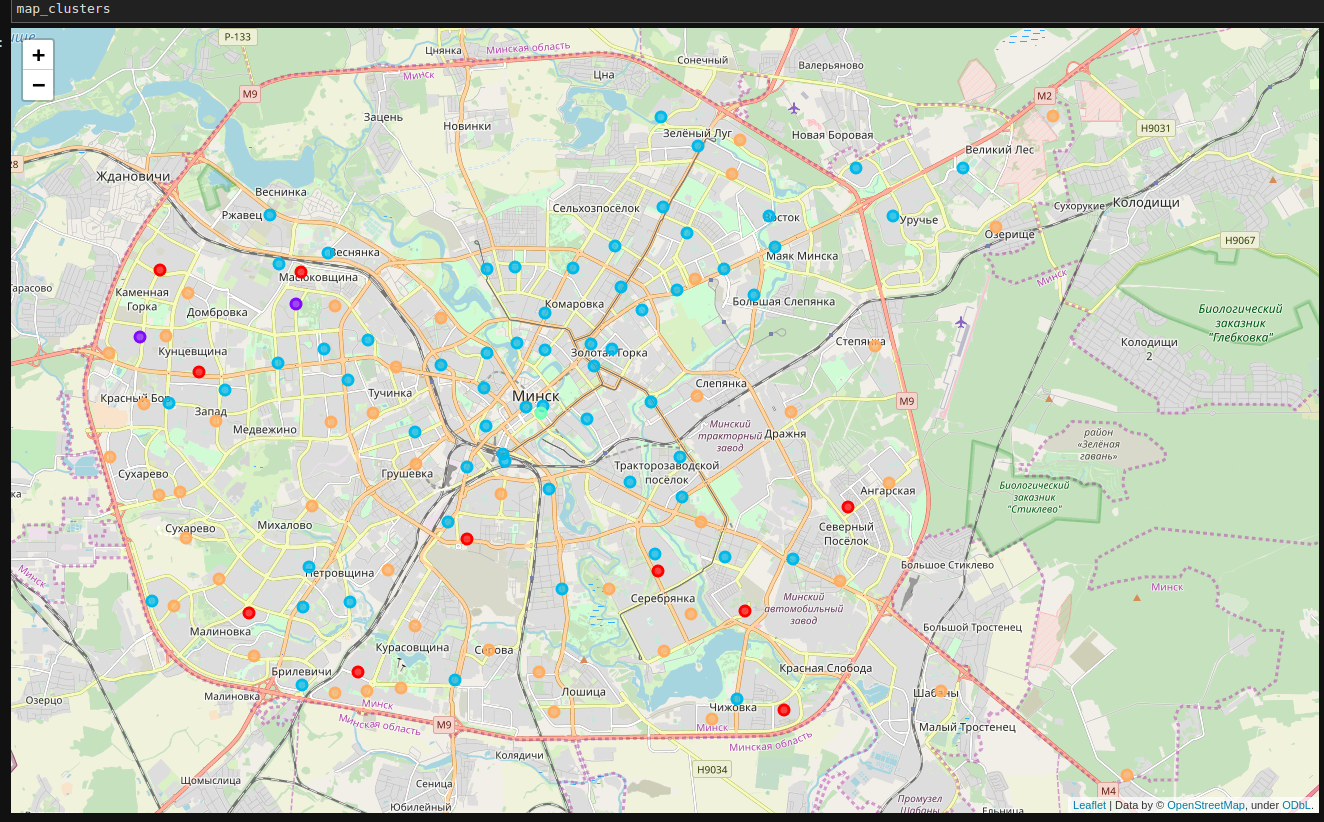

In [186]:
Image('minsk_clusters_map_v1.png')

# Clasters 

In [178]:
minsk_merged['cluster-label'].value_counts()

2    62
4    46
0    10
1     2
3     1
Name: cluster-label, dtype: int64

### Cluster 0

In [177]:
minsk_merged.loc[minsk_merged['cluster-label'] == 0, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,220058,Bus Stop,Grocery Store,Department Store,Martial Arts Dojo,Paper / Office Supplies Store,Big Box Store,Auto Garage,Gym,Sports Club,Flea Market
63,220065,Shopping Mall,Bus Stop,Cosmetics Shop,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market
87,220096,Bus Stop,Liquor Store,Supermarket,Food & Drink Shop,Department Store,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
96,220108,Bus Stop,Park,Farmers Market,Grocery Store,Sushi Restaurant,Cafeteria,Athletics & Sports,Event Space,Eye Doctor,Fabric Shop
98,220111,Bus Stop,Basketball Court,Zoo Exhibit,French Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market
104,220117,Bus Stop,Gym / Fitness Center,Hotel,Athletics & Sports,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant
105,220118,Bus Stop,Gym / Fitness Center,Reservoir,Grocery Store,Bus Line,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor
114,220128,Moving Target,Bus Stop,Department Store,Zoo Exhibit,Fish Market,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market
118,220137,Bus Stop,Grocery Store,Moving Target,Zoo Exhibit,Fast Food Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market
120,220140,Cosmetics Shop,Bus Stop,Bus Line,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant


### Cluster 1

In [179]:
minsk_merged.loc[minsk_merged['cluster-label'] == 1, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,220063,Convenience Store,Cruise,Cave,Park,Food & Drink Shop,Farmers Market,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
94,220104,Park,Convenience Store,Spa,Bath House,Food & Drink Shop,Bus Line,Food Court,Flower Shop,Flea Market,Fish Market


### Cluster 2

In [180]:
minsk_merged.loc[minsk_merged['cluster-label'] == 2, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,220001,Coffee Shop,Gym / Fitness Center,Hotel,Dance Studio,Doner Restaurant,Bakery,Metro Station,Theater,Spa,Souvenir Shop
1,220002,Hotel,Café,Coffee Shop,Cocktail Bar,Fountain,Bar,Park,Gym,Spa,Gym / Fitness Center
3,220004,Gym,Clothing Store,Concert Hall,Coffee Shop,Café,Wine Shop,Big Box Store,Bike Rental / Bike Share,Go Kart Track,Gift Shop
4,220005,Coffee Shop,Cosmetics Shop,Arcade,Dance Studio,Pharmacy,Wine Bar,Café,Sporting Goods Shop,Beer Bar,Tea Room
5,220006,Pharmacy,Athletics & Sports,Coffee Shop,Café,Soccer Field,Bike Trail,Bus Stop,Discount Store,Auto Garage,Auto Dealership
...,...,...,...,...,...,...,...,...,...,...,...
112,220126,Café,Italian Restaurant,Coffee Shop,Convenience Store,Clothing Store,Brewery,Plaza,Supermarket,Bookstore,Cafeteria
115,220131,Pharmacy,Bus Stop,Coffee Shop,Parking,Beer Bar,Auto Garage,Beach,Park,Food & Drink Shop,Furniture / Home Store
116,220134,Gym / Fitness Center,Coffee Shop,Café,Bookstore,Sushi Restaurant,Bus Stop,Spa,Pet Store,Rock Club,Clothing Store
117,220136,Gym / Fitness Center,Track,Bookstore,Supermarket,Sushi Restaurant,Coffee Shop,Lake,Farmers Market,Ethiopian Restaurant,Event Space


### Cluster 3

In [181]:
minsk_merged.loc[minsk_merged['cluster-label'] == 3, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,220030,Coffee Shop,Zoo Exhibit,Fast Food Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market


### Cluster 4

In [182]:
minsk_merged.loc[minsk_merged['cluster-label'] == 4, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,220003,Bus Stop,Department Store,Boutique,Pharmacy,Beer Store,Gourmet Shop,Park,Café,Hardware Store,Furniture / Home Store
6,220007,Bus Stop,Park,Athletics & Sports,Grocery Store,Belarusian Restaurant,Gym,Shoe Repair,Bakery,Metro Station,Auto Dealership
13,220014,Bus Stop,Cafeteria,Photography Studio,Café,Bistro,Soccer Field,Coffee Shop,Tourist Information Center,Auto Garage,Event Space
14,220015,Bus Stop,Gym,Auto Garage,Pub,Bus Line,Tailor Shop,Intersection,Grocery Store,Coffee Shop,Department Store
16,220017,Bus Stop,Big Box Store,Gym,Bakery,Supermarket,Boutique,Belarusian Restaurant,Casino,Shopping Mall,Park
17,220018,Gym / Fitness Center,Pizza Place,Park,Bus Stop,Café,Electronics Store,Hotel,Supermarket,Food & Drink Shop,Flower Shop
18,220019,Gym / Fitness Center,Pizza Place,Beer Store,Big Box Store,Bus Stop,Coffee Shop,Home Service,Gym,Yoga Studio,Fish Market
21,220022,Cafeteria,Bus Line,Pet Store,Pizza Place,Coffee Shop,Vape Store,Bus Stop,Farmers Market,Event Space,Eye Doctor
23,220024,Bus Stop,Farmers Market,Hardware Store,Café,Pharmacy,Salon / Barbershop,Bus Station,Shopping Mall,Pizza Place,Botanical Garden
24,220025,Bus Stop,Grocery Store,Food & Drink Shop,Cosmetics Shop,Pharmacy,Bookstore,Beer Store,Belarusian Restaurant,Big Box Store,Chocolate Shop


# and what a story i can tell about all of this ?....